In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
# from keras import Sequential
# from collections import deque
# from keras.layers import Dense
# # from keras.optimizers import Adam
# import matplotlib.pyplot as plt
# from keras.activations import relu, linear

In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from colabgymrender.recorder import Recorder

In [5]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


15.0


100%|██████████| 16/16 [00:00<00:00, 115.86it/s]


In [6]:
total_reward

15.0

In [6]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [7]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()
    
    return memory

In [9]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])
        #Chọn action dựa vào uniform distribution (0,1)
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)
        #Tương tác với môi trường để xem kết quả nhận về khi tương tác với môi trường là như thế nào
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        #Lưu experience vào memory
        memory.append(experience)
        #Cập nhận reward
        reward_per_episode += reward
        #Cập nhật đến state tiếp theo
        state = next_state

        #Cập nhật reward_bufer cho mỗi episode hoàn tất và reset lại buffer
        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        
        #Lấy một tập minibatch từ experience
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        #Tính targets sử dụng công thức sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        #Tính hàm loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        #Dùng GD cho q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Cập nhật target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        #Training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [10]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 43 Step: 1000 Average reward: 23.046511627906977
Episode: 86 Step: 2000 Average reward: 23.08139534883721
Episode: 127 Step: 3000 Average reward: 23.38
Episode: 155 Step: 4000 Average reward: 26.91
Episode: 178 Step: 5000 Average reward: 31.52
Episode: 201 Step: 6000 Average reward: 35.62
Episode: 224 Step: 7000 Average reward: 40.56
Episode: 240 Step: 8000 Average reward: 45.77
Episode: 250 Step: 9000 Average reward: 51.94
Episode: 256 Step: 10000 Average reward: 58.25
Episode: 262 Step: 11000 Average reward: 67.29
Episode: 267 Step: 12000 Average reward: 74.58
Episode: 272 Step: 13000 Average reward: 82.58
Episode: 277 Step: 14000 Average reward: 90.6
Episode: 282 Step: 15000 Average reward: 98.23
Episode: 287 Step: 16000 Average reward: 106.49
Episode: 292 Step: 17000 Average reward: 114.95
Episode: 297 Step: 18000 Average reward: 122.25
Episode: 302 Step: 19000 Average reward: 129.79
Episode: 307 Step: 20000 Average reward: 138.2
Episode: 312 Step: 21000 Average reward: 14

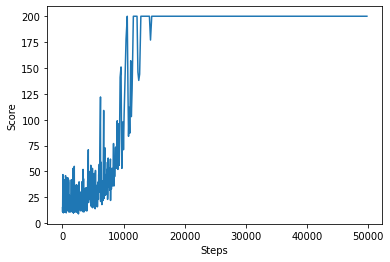

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [8]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

NameError: ignored

#Xây dựng mạng NN cho bài toán Moutain Car

In [9]:
#Tạo biến môi trường
env = gym.make('MountainCar-v0')
env.reset()

#Lấy state hiện tại sau khởi tạo
print(env.state)

[-0.57710407  0.        ]


State được cấu thành bởi coor của x-axis và vận tốc tại đó

In [10]:
#Kích thước không gian mà state có thể thực hiện 
print(env.action_space.n)

3


State bao gồm các bước đi qua trái, đứng yên và đi qua phải

In [11]:
#Lấy vị trí, vận tốc tối thiểu và tối đa của environment đó
print(env.observation_space.low)
print(env.observation_space.high)
### Đi từ -1.2->0.6 với vận tốc tương ứng -0.07->0.07

[-1.2  -0.07]
[0.6  0.07]


In [12]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 500000
epsilon_decay_intervals = 10000
gamma = 0.95 # discount
alpha = 0.001 # learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 256

target_update_frequency = 1000 # target network update frequency

In [13]:
class NeuralNetwork1(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork1, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, env.action_space.n)
            # #nn.ReLU(),
            # nn.Tanh(),
            # nn.Linear(64, env.action_space.n)
        )
        # self.network.add_module(Dense(20, input_dim=env.observation_space.shape[0], activation=relu))
        # self.network.add_module(Dense(25, activation=relu))
        # self.network.add_module(Dense(env.action_space.n, activation=linear))
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [14]:
def dqn_training1(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork1(env)
    target_net = NeuralNetwork1(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])
        #Chọn action dựa vào uniform distribution (0,1)
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)
        #Tương tác với môi trường để xem kết quả nhận về khi tương tác với môi trường là như thế nào
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        #Lưu experience vào memory
        memory.append(experience)
        #Cập nhận reward
        reward_per_episode += reward
        #Cập nhật đến state tiếp theo
        state = next_state

        #Cập nhật reward_bufer cho mỗi episode hoàn tất và reset lại buffer
        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        
        #Lấy một tập minibatch từ experience
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        #Tính targets sử dụng công thức sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        #Tính hàm loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        #Dùng GD cho q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Cập nhật target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        #Training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [15]:
all_rewards,  q_net = dqn_training1(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)
print(all_rewards)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -199.8
Episode: 85 Step: 17000 Average reward: -199.81176470588235
Episode: 90 Step: 18000 Average reward: -199.82222222222222
Episode: 95 Step: 19000 Average reward: -199.83157894736843
Episode: 100 Step: 20000 Average reward: -199.84
Episode: 105 Step: 21000 Aver

In [16]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        # action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

-193.0


100%|██████████| 195/195 [00:00<00:00, 326.60it/s]


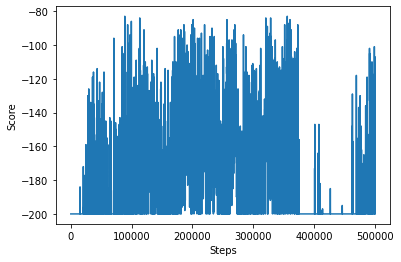

In [17]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

Nhận xét: Ở đây, sau khi thực nghiệm nhiều model, em đã đúc kết được việc sử dụng 2 lớp FC và bộ hyper param như trên. Train gấp 10 lần episode bài trước.
